In [1]:
# takes 7m for 3m hand records
# perform experiments on standardized hand records.

# next steps:
# acbl-hand-records-train-...-experiments.ipynb experiments with the trained data

# previous steps:
# acbl-hand-records-cleanup.ipynb created acbl_hand_records_cleaned.pkl

# todo:
# save model predictions
# let model know North hands. how? in terms of one hot 52 cards or 13/suit? QT? 
# plot accuracy of model
# remove all metrics except m.score?
# remove obsolete validation_df from model
# try feature scaling to improve accuracy?
# try changing activation function to sigmod/tanh/relu
# try using scikit's optimizer to try out various models.

# models:
# how often can expert bridge players predict dd? how can this be determined?
# create model to predict par score. different than dd?
# vary dd, hcp, sl to see how it effects predictions.
# chart of dd given sl and hcp is important. how does chart compare to predictions?
# show accuracy for each model

In [2]:
import pandas as pd
import pathlib
import pickle
import re
from collections import defaultdict
from IPython.display import display # needed to define display() method in vscode
import sys

In [3]:
sys.path.append(str(pathlib.Path.cwd().parent.joinpath('mlBridgeLib')))
sys.path
import mlBridgeLib

In [4]:
# override pandas display options
mlBridgeLib.pd_options_display()

In [5]:
rootPath = pathlib.Path('e:/bridge/data')
acblPath = rootPath.joinpath('acbl')
savedModelsPath = acblPath.joinpath('SavedModels')
# create parent directories in case they don't already exist.
savedModelsPath.mkdir(parents=True, exist_ok=True)

In [6]:
# takes 15s (varies greatly) for 2,700,000 rows.
# todo: fix error (currently ignored): AttributeError: 'StringDtype' object has no attribute 'storage'
# read file containing boards which were reported by both acbl and tcg.
acbl_hand_records_cleaned_filename = 'acbl_hand_records_cleaned.pkl'
acbl_hand_records_cleaned_file = acblPath.joinpath(acbl_hand_records_cleaned_filename)
df = pd.read_pickle(acbl_hand_records_cleaned_file)
display(len(df),df.info(),df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3603864 entries, 0 to 3609880
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   ref                  object
 1   hand_record_id       object
 2   event_id             int64 
 3   Board                string
 4   EventBoard           string
 5   Dealer               object
 6   Vul                  object
 7   board_record_string  object
 8   Hands                object
 9   Par                  object
 10  DDmakes              object
 11  brs_dup              bool  
dtypes: bool(1), int64(1), object(8), string(2)
memory usage: 333.4+ MB


3603864

None

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False
3,"(acbl, 2620420)",77908,100961,28,200217A_28,W,N_S,STHQJ9632DJ9CJ932SKQH8DQT86542CT76SJ76HATDAK3CAKQ84SA985432HK754D7C5,"((T, QJ9632, J9, J932), (J76, AT, AK3, AKQ84), (A985432, K754, 7, 5), (KQ, 8, QT86542, T76))","(-460, [(5, N, , EW, 0)])","((1, 0, 10, 8, 1), (11, 11, 3, 5, 11), (0, 0, 10, 8, 0), (11, 11, 3, 5, 11))",False
4,"(acbl, 2620399)",77908,100961,07,200217A_07,S,Both,S2HQT762D92CAKT92SAKJ7HA8DKJ4C8643SQT854HK43DA765CQS963HJ95DQT83CJ75,"((2, QT762, 92, AKT92), (QT854, K43, A765, Q), (963, J95, QT83, J75), (AKJ7, A8, KJ4, 8643))","(-1430, [(6, S, , EW, 0)])","((6, 2, 6, 1, 3), (7, 11, 6, 12, 8), (6, 2, 6, 1, 3), (7, 11, 6, 12, 8))",False
5,"(acbl, 2620396)",77908,100961,04,200217A_04,W,Both,S84HAKJ83D4CQT743SA65HQ62DQ8732CK8SJ972HT5DAKJ96C95SKQT3H974DT5CAJ62,"((84, AKJ83, 4, QT743), (J972, T5, AKJ96, 95), (KQT3, 974, T5, AJ62), (A65, Q62, Q8732, K8))","(620, [(4, H, , NS, 0)])","((10, 5, 10, 6, 6), (3, 8, 3, 6, 6), (10, 5, 10, 6, 6), (3, 8, 3, 6, 6))",False
6,"(acbl, 2620410)",77908,100961,18,200217A_18,E,N_S,S872HJ8753DQ873CASAJ65HQ4DAKJ4C874S93HAK6D962CQT963SKQT4HT92DT5CKJ52,"((872, J8753, Q873, A), (93, AK6, 962, QT963), (KQT4, T92, T5, KJ52), (AJ65, Q4, AKJ4, 874))","(-120, [(1, N, , EW, 1)])","((4, 4, 5, 5, 5), (9, 8, 7, 7, 8), (4, 5, 5, 5, 5), (9, 8, 7, 7, 8))",False
7,"(acbl, 2620400)",77908,100961,08,200217A_08,W,None,S953H98642DJ9CKJ5SAJT6HAJ3DT2CAT96S742HKQ7DK764CQ43SKQ8HT5DAQ853C872,"((953, 98642, J9, KJ5), (742, KQ7, K764, Q43), (KQ8, T5, AQ853, 872), (AJT6, AJ3, T2, AT96))","(-140, [(1, S, , E, 2)])","((4, 6, 6, 4, 5), (8, 7, 7, 9, 8), (4, 6, 6, 4, 5), (8, 7, 7, 8, 8))",False
8,"(acbl, 2620397)",77908,100961,05,200217A_05,N,N_S,S98HAKT83D84CAQ82SQJHQJ65DT2CJ7653SAK752H72DAK96CKTST643H94DQJ753C94,"((98, AKT83, 84, AQ82), (AK752, 72, AK96, KT), (T643, 94, QJ753, 94), (QJ, QJ65, T2, J7653))","(-120, [(2, N, , EW, 0)])","((5, 6, 7, 4, 5), (7, 7, 6, 8, 8), (5, 6, 7, 4, 5), (7, 7, 6, 8, 8))",False
9,"(acbl, 2620398)",77908,100961,06,200217A_06,E,E_W,SA53HJT8DQ8743CQ9SKQJT87H954DJCA62S94HAQ62DAT965C54S62HK73DK2CKJT873,"((A53, JT8, Q8743, Q9), (94, AQ62, AT965, 54), (62, K73, K2, KJT873), (KQJT87, 954, J, A62))","(-140, [(2, S, , EW, 1)])","((7, 6, 5, 4, 5), (5, 7, 8, 9, 5), (7, 6, 5, 4, 5), (5, 7, 8, 9, 5))",False


In [7]:
df = df.drop_duplicates(subset=['board_record_string'])
df

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False
3,"(acbl, 2620420)",77908,100961,28,200217A_28,W,N_S,STHQJ9632DJ9CJ932SKQH8DQT86542CT76SJ76HATDAK3CAKQ84SA985432HK754D7C5,"((T, QJ9632, J9, J932), (J76, AT, AK3, AKQ84), (A985432, K754, 7, 5), (KQ, 8, QT86542, T76))","(-460, [(5, N, , EW, 0)])","((1, 0, 10, 8, 1), (11, 11, 3, 5, 11), (0, 0, 10, 8, 0), (11, 11, 3, 5, 11))",False
4,"(acbl, 2620399)",77908,100961,07,200217A_07,S,Both,S2HQT762D92CAKT92SAKJ7HA8DKJ4C8643SQT854HK43DA765CQS963HJ95DQT83CJ75,"((2, QT762, 92, AKT92), (QT854, K43, A765, Q), (963, J95, QT83, J75), (AKJ7, A8, KJ4, 8643))","(-1430, [(6, S, , EW, 0)])","((6, 2, 6, 1, 3), (7, 11, 6, 12, 8), (6, 2, 6, 1, 3), (7, 11, 6, 12, 8))",False
5,"(acbl, 2620396)",77908,100961,04,200217A_04,W,Both,S84HAKJ83D4CQT743SA65HQ62DQ8732CK8SJ972HT5DAKJ96C95SKQT3H974DT5CAJ62,"((84, AKJ83, 4, QT743), (J972, T5, AKJ96, 95), (KQT3, 974, T5, AJ62), (A65, Q62, Q8732, K8))","(620, [(4, H, , NS, 0)])","((10, 5, 10, 6, 6), (3, 8, 3, 6, 6), (10, 5, 10, 6, 6), (3, 8, 3, 6, 6))",False
6,"(acbl, 2620410)",77908,100961,18,200217A_18,E,N_S,S872HJ8753DQ873CASAJ65HQ4DAKJ4C874S93HAK6D962CQT963SKQT4HT92DT5CKJ52,"((872, J8753, Q873, A), (93, AK6, 962, QT963), (KQT4, T92, T5, KJ52), (AJ65, Q4, AKJ4, 874))","(-120, [(1, N, , EW, 1)])","((4, 4, 5, 5, 5), (9, 8, 7, 7, 8), (4, 5, 5, 5, 5), (9, 8, 7, 7, 8))",False
7,"(acbl, 2620400)",77908,100961,08,200217A_08,W,None,S953H98642DJ9CKJ5SAJT6HAJ3DT2CAT96S742HKQ7DK764CQ43SKQ8HT5DAQ853C872,"((953, 98642, J9, KJ5), (742, KQ7, K764, Q43), (KQ8, T5, AQ853, 872), (AJT6, AJ3, T2, AT96))","(-140, [(1, S, , E, 2)])","((4, 6, 6, 4, 5), (8, 7, 7, 9, 8), (4, 6, 6, 4, 5), (8, 7, 7, 8, 8))",False
8,"(acbl, 2620397)",77908,100961,05,200217A_05,N,N_S,S98HAKT83D84CAQ82SQJHQJ65DT2CJ7653SAK752H72DAK96CKTST643H94DQJ753C94,"((98, AKT83, 84, AQ82), (AK752, 72, AK96, KT), (T643, 94, QJ753, 94), (QJ, QJ65, T2, J7653))","(-120, [(2, N, , EW, 0)])","((5, 6, 7, 4, 5), (7, 7, 6, 8, 8), (5, 6, 7, 4, 5), (7, 7, 6, 8, 8))",False
9,"(acbl, 2620398)",77908,100961,06,200217A_06,E,E_W,SA53HJT8DQ8743CQ9SKQJT87H954DJCA62S94HAQ62DAT965C54S62HK73DK2CKJT873,"((A53, JT8, Q8743, Q9), (94, AQ62, AT965, 54), (62, K73, K2, KJT873), (KQJT87, 954, J, A62))","(-140, [(2, S, , EW, 1)])","((7, 6, 5, 4, 5), (5, 7, 8, 9, 5), (7, 6, 5, 4, 5), (5, 7, 8, 9, 5))",False


In [8]:
augmented_df = df.copy().reset_index(drop=True) # must reset index so list appends sync properly
del df

In [9]:
assert augmented_df.isna().sum().sum() == 0 # must not contain NAs

In [10]:
# takes 20s
# Create columns of double dummy by direction by suit. e.g. DD_N_C.
def Augment_DDmakes(ddmakes):
    ddmakesd = defaultdict(list)
    for dd in ddmakes:
        for direction,nesw in zip(mlBridgeLib.NESW,dd):
            for suit,cdhsn in zip(mlBridgeLib.CDHSN,nesw):
                assert cdhsn is not None
                ddmakesd['_'.join(['DD',direction,suit])].append(cdhsn)
    return ddmakesd

ddmakesd = Augment_DDmakes(augmented_df['DDmakes'])
ddmakesdf = pd.DataFrame(ddmakesd,dtype='int8')
display(ddmakesdf.dtypes,ddmakesdf.head())
assert len(augmented_df) == len(ddmakesdf)
augmented_df = pd.concat([augmented_df,ddmakesdf],axis='columns',join='inner')
del ddmakesdf,ddmakesd
display(augmented_df.dtypes,augmented_df)

DD_N_C    int8
DD_N_D    int8
DD_N_H    int8
DD_N_S    int8
DD_N_N    int8
DD_E_C    int8
DD_E_D    int8
DD_E_H    int8
DD_E_S    int8
DD_E_N    int8
DD_S_C    int8
DD_S_D    int8
DD_S_H    int8
DD_S_S    int8
DD_S_N    int8
DD_W_C    int8
DD_W_D    int8
DD_W_H    int8
DD_W_S    int8
DD_W_N    int8
dtype: object

,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N
0,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2
1,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6
2,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6
3,1,0,10,8,1,11,11,3,5,11,0,0,10,8,0,11,11,3,5,11
4,6,2,6,1,3,7,11,6,12,8,6,2,6,1,3,7,11,6,12,8


ref                    object
hand_record_id         object
event_id                int64
Board                  string
EventBoard             string
Dealer                 object
Vul                    object
board_record_string    object
Hands                  object
Par                    object
DDmakes                object
brs_dup                  bool
DD_N_C                   int8
DD_N_D                   int8
DD_N_H                   int8
DD_N_S                   int8
DD_N_N                   int8
DD_E_C                   int8
DD_E_D                   int8
DD_E_H                   int8
DD_E_S                   int8
DD_E_N                   int8
DD_S_C                   int8
DD_S_D                   int8
DD_S_H                   int8
DD_S_S                   int8
DD_S_N                   int8
DD_W_C                   int8
DD_W_D                   int8
DD_W_H                   int8
DD_W_S                   int8
DD_W_N                   int8
dtype: object

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6
3,"(acbl, 2620420)",77908,100961,28,200217A_28,W,N_S,STHQJ9632DJ9CJ932SKQH8DQT86542CT76SJ76HATDAK3CAKQ84SA985432HK754D7C5,"((T, QJ9632, J9, J932), (J76, AT, AK3, AKQ84), (A985432, K754, 7, 5), (KQ, 8, QT86542, T76))","(-460, [(5, N, , EW, 0)])","((1, 0, 10, 8, 1), (11, 11, 3, 5, 11), (0, 0, 10, 8, 0), (11, 11, 3, 5, 11))",False,1,0,10,8,1,11,11,3,5,11,0,0,10,8,0,11,11,3,5,11
4,"(acbl, 2620399)",77908,100961,07,200217A_07,S,Both,S2HQT762D92CAKT92SAKJ7HA8DKJ4C8643SQT854HK43DA765CQS963HJ95DQT83CJ75,"((2, QT762, 92, AKT92), (QT854, K43, A765, Q), (963, J95, QT83, J75), (AKJ7, A8, KJ4, 8643))","(-1430, [(6, S, , EW, 0)])","((6, 2, 6, 1, 3), (7, 11, 6, 12, 8), (6, 2, 6, 1, 3), (7, 11, 6, 12, 8))",False,6,2,6,1,3,7,11,6,12,8,6,2,6,1,3,7,11,6,12,8
5,"(acbl, 2620396)",77908,100961,04,200217A_04,W,Both,S84HAKJ83D4CQT743SA65HQ62DQ8732CK8SJ972HT5DAKJ96C95SKQT3H974DT5CAJ62,"((84, AKJ83, 4, QT743), (J972, T5, AKJ96, 95), (KQT3, 974, T5, AJ62), (A65, Q62, Q8732, K8))","(620, [(4, H, , NS, 0)])","((10, 5, 10, 6, 6), (3, 8, 3, 6, 6), (10, 5, 10, 6, 6), (3, 8, 3, 6, 6))",False,10,5,10,6,6,3,8,3,6,6,10,5,10,6,6,3,8,3,6,6
6,"(acbl, 2620410)",77908,100961,18,200217A_18,E,N_S,S872HJ8753DQ873CASAJ65HQ4DAKJ4C874S93HAK6D962CQT963SKQT4HT92DT5CKJ52,"((872, J8753, Q873, A), (93, AK6, 962, QT963), (KQT4, T92, T5, KJ52), (AJ65, Q4, AKJ4, 874))","(-120, [(1, N, , EW, 1)])","((4, 4, 5, 5, 5), (9, 8, 7, 7, 8), (4, 5, 5, 5, 5), (9, 8, 7, 7, 8))",False,4,4,5,5,5,9,8,7,7,8,4,5,5,5,5,9,8,7,7,8
7,"(acbl, 2620400)",77908,100961,08,200217A_08,W,None,S953H98642DJ9CKJ5SAJT6HAJ3DT2CAT96S742HKQ7DK764CQ43SKQ8HT5DAQ853C872,"((953, 98642, J9, KJ5), (742, KQ7, K764, Q43), (KQ8, T5, AQ853, 872), (AJT6, AJ3, T2, AT96))","(-140, [(1, S, , E, 2)])","((4, 6, 6, 4, 5), (8, 7, 7, 9, 8), (4, 6, 6, 4, 5), (8, 7, 7, 8, 8))",False,4,6,6,4,5,8,7,7,9,8,4,6,6,4,5,8,7,7,8,8
8,"(acbl, 2620397)",77908,100961,05,200217A_05,N,N_S,S98HAKT83D84CAQ82SQJHQJ65DT2CJ7653SAK752H72DAK96CKTST643H94DQJ753C94,"((98, AKT83, 84, AQ82), (AK752, 72, AK96, KT), (T643, 94, QJ753, 94), (QJ, QJ65, T2, J7653))","(-120, [(2, N, , EW, 0)])","((5, 6, 7, 4, 5), (7, 7, 6, 8, 8), (5, 6, 7, 4, 5), (7, 7, 6, 8, 8))",False,5,6,7,4,5,7,7,6,8,8,5,6,7,4,5,7,7,6,8,8
9,"(acbl, 2620398)",77908,100961,06,200217A_06,E,E_W,SA53HJT8DQ8743CQ9SKQJT87H954DJCA62S94HAQ62DAT965C54S62HK73DK2CKJT873,"((A53, JT8, Q8743, Q9), (94, AQ62, AT965, 54), (62, K73, K2, KJT873), (KQJT87, 954, J, A62))","(-140, [(2, S, , EW, 1)])","((7, 6, 5, 4, 5), (5, 7, 8, 9, 5), (7, 6, 5, 4, 5), (5, 7, 8, 9, 5))",False,7,6,5,4,5,5,7,8,9,5,7,6,5,4,5,5,7,8,9,5


In [11]:
# takes 40s
# create column of Hands expressed in binary.
assert 'Hands_Bin' not in augmented_df.columns
augmented_df['Hands_Bin'] = augmented_df['Hands'].map(mlBridgeLib.HandsToBin)
augmented_df.head()

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001..."
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110..."
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6,"((0b100000000000000011010010100100000010011000011010, (0b100000000, 0b110100, 0b1010010000001, 0..."
3,"(acbl, 2620420)",77908,100961,28,200217A_28,W,N_S,STHQJ9632DJ9CJ932SKQH8DQT86542CT76SJ76HATDAK3CAKQ84SA985432HK754D7C5,"((T, QJ9632, J9, J932), (J76, AT, AK3, AKQ84), (A985432, K754, 7, 5), (KQ, 8, QT86542, T76))","(-460, [(5, N, , EW, 0)])","((1, 0, 10, 8, 1), (11, 11, 3, 5, 11), (0, 0, 10, 8, 0), (11, 11, 3, 5, 11))",False,1,0,10,8,1,11,11,3,5,11,0,0,10,8,0,11,11,3,5,11,"((0b100000000001101001001100010100000000001010000011, (0b100000000, 0b11010010011, 0b1010000000,..."
4,"(acbl, 2620399)",77908,100961,07,200217A_07,S,Both,S2HQT762D92CAKT92SAKJ7HA8DKJ4C8643SQT854HK43DA765CQS963HJ95DQT83CJ75,"((2, QT762, 92, AKT92), (QT854, K43, A765, Q), (963, J95, QT83, J75), (AKJ7, A8, KJ4, 8643))","(-1430, [(6, S, , EW, 0)])","((6, 2, 6, 1, 3), (7, 11, 6, 12, 8), (6, 2, 6, 1, 3), (7, 11, 6, 12, 8))",False,6,2,6,1,3,7,11,6,12,8,6,2,6,1,3,7,11,6,12,8,"((0b1001010011000100000100000011100110000001, (0b1, 0b10100110001, 0b10000001, 0b1100110000001))..."


In [12]:
len(augmented_df)

1741626

In [13]:
# takes 6s
# Create one hot encoding, length 52, for each direction's hand.
# todo: one hot encode each direction's hand? Leaving as binary string for now.
def OHE_Hands(hands_bin):
    handsbind = defaultdict(list)
    for h in hands_bin:
        for direction,nesw in zip(mlBridgeLib.NESW,h):
            assert nesw[0] is not None and nesw[1] is not None
            handsbind['_'.join(['HB',direction])].append(nesw[0]) # todo: int(nesw[0],2)) # convert binary string to base 2 int
            #for suit,shdc in zip(mlBridgeLib.SHDC,nesw[1]):
            #    assert shdc is not None
            #    handsbind['_'.join(['HCP',direction,suit])].append(shdc)
    return handsbind

handsbind = OHE_Hands(augmented_df['Hands_Bin'])
handsbindf = pd.DataFrame(handsbind,dtype='string') # need 52 bits
display(handsbindf.dtypes,len(handsbindf),len(augmented_df),handsbindf.head())
assert len(augmented_df) == len(handsbindf)
augmented_df = pd.concat([augmented_df,handsbindf],axis='columns',join='inner')
del handsbindf,handsbind
display(augmented_df.dtypes,augmented_df)

HB_N    string
HB_E    string
HB_S    string
HB_W    string
dtype: object

1741626

1741626

,HB_N,HB_E,HB_S,HB_W
0,0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000
1,0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100
2,0b100000000000000011010010100100000010011000011010,0b100011000100000000000100000001011001100000011100000,0b1000000001001101001100001101010000000000000000000101,0b11000110010010110000000000000000110001100100000000
3,0b100000000001101001001100010100000000001010000011,0b1000110000100010000000011000000000101110001000100,0b1000011001111010000010110000000001000000000000001000,0b110000000000000000100000000101010111010000100110000
4,0b1001010011000100000100000011100110000001,0b10101001100010000000011010000001110000010000000000,0b10010010000101000100000101010000100001000101000,0b1101000100000100000100000001010000001000000001010110


ref                    object
hand_record_id         object
event_id                int64
Board                  string
EventBoard             string
Dealer                 object
Vul                    object
board_record_string    object
Hands                  object
Par                    object
DDmakes                object
brs_dup                  bool
DD_N_C                   int8
DD_N_D                   int8
DD_N_H                   int8
DD_N_S                   int8
DD_N_N                   int8
DD_E_C                   int8
DD_E_D                   int8
DD_E_H                   int8
DD_E_S                   int8
DD_E_N                   int8
DD_S_C                   int8
DD_S_D                   int8
DD_S_H                   int8
DD_S_S                   int8
DD_S_N                   int8
DD_W_C                   int8
DD_W_D                   int8
DD_W_H                   int8
DD_W_S                   int8
DD_W_N                   int8
Hands_Bin              object
HB_N      

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6,"((0b100000000000000011010010100100000010011000011010, (0b100000000, 0b110100, 0b1010010000001, 0...",0b100000000000000011010010100100000010011000011010,0b100011000100000000000100000001011001100000011100000,0b1000000001001101001100001101010000000000000000000101,0b11000110010010110000000000000000110001100100000000
3,"(acbl, 2620420)",77908,100961,28,200217A_28,W,N_S,STHQJ9632DJ9CJ932SKQH8DQT86542CT76SJ76HATDAK3CAKQ84SA985432HK754D7C5,"((T, QJ9632, J9, J932), (J76, AT, AK3, AKQ84), (A985432, K754, 7, 5), (KQ, 8, QT86542, T76))","(-460, [(5, N, , EW, 0)])","((1, 0, 10, 8, 1), (11, 11, 3, 5, 11), (0, 0, 10, 8, 0), (11, 11, 3, 5, 11))",False,1,0,10,8,1,11,11,3,5,11,0,0,10,8,0,11,11,3,5,11,"((0b100000000001101001001100010100000000001010000011, (0b100000000, 0b11010010011, 0b1010000000,...",0b100000000001101001001100010100000000001010000011,0b1000110000100010000000011000000000101110001000100,0b1000011001111010000010110000000001000000000000001000,0b110000000000000000100000000101010111010000100110000
4,"(acbl, 2620399)",77908,100961,07,200217A_07,S,Both,S2HQT762D92CAKT92SAKJ7HA8DKJ4C8643SQT854HK43DA765CQS963HJ95DQT83CJ75,"((2, QT762, 92, AKT92), (QT854, K43, A765, Q), (963, J95, QT83, J75), (AKJ7, A8, KJ4, 8643))","(-1430, [(6, S, , EW, 0)])","((6, 2, 6, 1, 3), (7, 11, 6, 12, 8), (6, 2, 6, 1, 3), (7, 11, 6, 12, 8))",False,6,2,6,1,3,7,11,6,12,8,6,2,6,1,3,7,11,6,12,8,"((0b1001010011000100000100000011100110000001, (0b1, 0b10100110001, 0b10000001, 0b1100110000001))...",0b1001010011000100000100000011100110000001,0b10101001100010000000011010000001110000010000000000,0b10010010000101000100000101010000100001000101000,0b1101000100000100000100000001010000001000000001010110
5,"(acbl, 2620396)",77908,100961,04,200217A_04,W,Both,S84HAKJ83D4CQT743SA65HQ62DQ8732CK8SJ972HT5DAKJ96C95SKQT3H974DT5CAJ62,"((84, AKJ83, 4, QT743), (J972, T5, AKJ96, 95), (KQT3, 974, T5, AJ62), (A65, Q62, Q8732, K8))","(620, [(4, H, , NS, 0)])","((10, 5, 10, 6, 6), (3, 8, 3, 6, 6), (10, 

In [14]:
# takes 25s
# Compute HCPs from Hands. Validate against any existing HCP column.
assert 'HCP' not in augmented_df.columns
augmented_df['HCP'] = augmented_df['Hands'].map(mlBridgeLib.HandsToHCP)

In [15]:
# takes 20s
# Compute HCP per direction, per suit.
def Augment_HCP(hcps):
    hcpsd = defaultdict(list)
    for h in hcps:
        for direction,nesw in zip(mlBridgeLib.NESW,h):
            assert nesw[0] is not None and nesw[1] is not None
            hcpsd['_'.join(['HCP',direction])].append(nesw[0])
            for suit,shdc in zip(mlBridgeLib.SHDC,nesw[1]):
                assert shdc is not None
                hcpsd['_'.join(['HCP',direction,suit])].append(shdc)
    return hcpsd

hcpsd = Augment_HCP(augmented_df['HCP'])
hcpsdf = pd.DataFrame(hcpsd,dtype='int8')
display(hcpsdf.dtypes,hcpsdf.head())
assert len(augmented_df) == len(hcpsdf)
augmented_df = pd.concat([augmented_df,hcpsdf],axis='columns',join='inner')
del hcpsdf,hcpsd
display(augmented_df.dtypes,augmented_df)

HCP_N      int8
HCP_N_S    int8
HCP_N_H    int8
HCP_N_D    int8
HCP_N_C    int8
HCP_E      int8
HCP_E_S    int8
HCP_E_H    int8
HCP_E_D    int8
HCP_E_C    int8
HCP_S      int8
HCP_S_S    int8
HCP_S_H    int8
HCP_S_D    int8
HCP_S_C    int8
HCP_W      int8
HCP_W_S    int8
HCP_W_H    int8
HCP_W_D    int8
HCP_W_C    int8
dtype: object

,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C
0,9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2
1,9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0
2,9,0,0,6,3,3,3,0,0,0,14,4,6,4,0,14,3,4,0,7
3,5,0,3,1,1,21,1,4,7,9,7,4,3,0,0,7,5,0,2,0
4,9,0,2,0,7,11,2,3,4,2,4,0,1,2,1,16,8,4,4,0


ref                    object
hand_record_id         object
event_id                int64
Board                  string
EventBoard             string
Dealer                 object
Vul                    object
board_record_string    object
Hands                  object
Par                    object
DDmakes                object
brs_dup                  bool
DD_N_C                   int8
DD_N_D                   int8
DD_N_H                   int8
DD_N_S                   int8
DD_N_N                   int8
DD_E_C                   int8
DD_E_D                   int8
DD_E_H                   int8
DD_E_S                   int8
DD_E_N                   int8
DD_S_C                   int8
DD_S_D                   int8
DD_S_H                   int8
                        ...  
HB_N                   string
HB_E                   string
HB_S                   string
HB_W                   string
HCP                    object
HCP_N                    int8
HCP_N_S                  int8
HCP_N_H   

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W,HCP,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000,"((9, (0, 3, 1, 5)), (14, (4, 2, 5, 3)), (12, (3, 5, 4, 0)), (5, (3, 0, 0, 2)))",9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100,"((9, (0, 4, 1, 4)), (9, (5, 0, 0, 4)), (13, (3, 2, 6, 2)), (9, (2, 4, 3, 0)))",9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6,"((0b100000000000000011010010100100000010011000011010, (0b100000000, 0b110100, 0b1010010000001, 0...",0b100000000000000011010010100100000010011000011010,0b100011000100000000000100000001011001100000011100000,0b1000000001001101001100001101010000000000000000000101,0b11000110010010110000000000000000110001100100000000,"((9, (0, 0, 6, 3)), (3, (3, 0, 0, 0)), (14, (4, 6, 4, 0)), (14, (3, 4, 0, 7)))",9,0,0,6,3,3,3,0,0,0,14,4,6,4,0,14,3,4,0,7
3,"(acbl, 2620420)",77908,100961,28,200217A_28,W,N_S,STHQJ9632DJ9CJ932SKQH8DQT86542CT76SJ76HATDAK3CAKQ84SA985432HK754D7C5,"((T, QJ9632, J9, J932), (J76, AT, AK3, AKQ84), (A985432, K754, 7, 5), (KQ, 8, QT86542, T76))","(-460, [(5, N, , EW, 0)])","((1, 0, 10, 8, 1), (11, 11, 3, 5, 11), (0, 0, 10, 8, 0), (11, 11, 3, 5, 11))",False,1,0,10,8,1,11,11,3,5,11,0,0,10,8,0,11,11,3,5,11,"((0b100000000001101001001100010100000000001010000011, (0b100000000, 0b11010010011, 0b1010000000,...",0b100000000001101001001100010100000000001010000011,0b1000110000100010000000011000000000101110001000100,0b1000011001111010000010110000000001000000000000001000,0b110000000000000000100000000101010111010000100110000,"((5, (0, 3, 1, 1)), (21, (1, 4, 7, 9)), (7, (4, 3, 0, 0)), (7, (5, 0, 2, 0)))",5,0,3,1,1,21,1,4,7,9,7,4,3,0,0,7,5,0,2,0
4,"(acbl, 2620399)",77908,100961,07,200217A_07,S,Both,S2HQT762D92CAKT92SAKJ7HA8DKJ4C8643SQT854HK43DA765CQS963HJ95DQT83CJ75,"((2, QT762, 92, AKT92), (QT854, K43, A765, Q), (963, J95, QT83, J75), (AKJ7, A8, KJ4, 8643))","(-1430, [(6, S, , EW, 0)])","((6, 2, 6, 1, 3), (7, 11, 6, 12, 8), (6, 2, 6, 1, 3), (7, 11, 6, 12, 8)

In [16]:
# takes 30s
# Compute quick tricks from Hands
assert 'QT' not in augmented_df.columns
augmented_df['QT'] = augmented_df['Hands'].map(mlBridgeLib.HandsToQT)

In [17]:
# takes 20s
# Compute quick tricks per direction, per suit.
def Augment_QT(qts):
    qts_d = defaultdict(list)
    for qt in qts:
        for direction,nesw in zip(mlBridgeLib.NESW,qt[1]):
            assert nesw[0] is not None and nesw[1] is not None
            qts_d['_'.join(['QT',direction])].append(nesw[0]) # qt total per direction
            for suit,shdc in zip(mlBridgeLib.SHDC,nesw[1]):
                assert shdc is not None
                qts_d['_'.join(['QT',direction,suit])].append(shdc) # qt per direction per suit
    return qts_d

qts_d = Augment_QT(augmented_df['QT'])
qts_df = pd.DataFrame(qts_d,dtype='float32')
display(qts_df.dtypes,qts_df.head())
assert len(augmented_df) == len(qts_df)
augmented_df = pd.concat([augmented_df,qts_df],axis='columns',join='inner')
del qts_df,qts_d
display(augmented_df.dtypes,augmented_df)

QT_N      float32
QT_N_S    float32
QT_N_H    float32
QT_N_D    float32
QT_N_C    float32
QT_E      float32
QT_E_S    float32
QT_E_H    float32
QT_E_D    float32
QT_E_C    float32
QT_S      float32
QT_S_S    float32
QT_S_H    float32
QT_S_D    float32
QT_S_C    float32
QT_W      float32
QT_W_S    float32
QT_W_H    float32
QT_W_D    float32
QT_W_C    float32
dtype: object

,QT_N,QT_N_S,QT_N_H,QT_N_D,QT_N_C,QT_E,QT_E_S,QT_E_H,QT_E_D,QT_E_C,QT_S,QT_S_S,QT_S_H,QT_S_D,QT_S_C,QT_W,QT_W_S,QT_W_H,QT_W_D,QT_W_C
0,1.50,0.00,0.50,0.00,1.00,2.50,1.00,0.00,1.00,0.50,2.50,0.50,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,0.00,0.50,0.00,0.50,2.00,1.00,0.00,0.00,1.00,2.00,0.50,0.00,1.50,0.00,1.50,0.00,1.00,0.50,0.00
2,1.50,0.00,0.00,1.50,0.00,0.50,0.50,0.00,0.00,0.00,3.00,1.00,1.50,0.50,0.00,2.50,0.00,0.50,0.00,2.00
3,0.00,0.00,0.00,0.00,0.00,5.00,0.00,1.00,2.00,2.00,1.50,1.00,0.50,0.00,0.00,1.00,1.00,0.00,0.00,0.00
4,2.00,0.00,0.00,0.00,2.00,1.50,0.00,0.50,1.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,2.00,1.00,0.50,0.00


ref                     object
hand_record_id          object
event_id                 int64
Board                   string
EventBoard              string
Dealer                  object
Vul                     object
board_record_string     object
Hands                   object
Par                     object
DDmakes                 object
brs_dup                   bool
DD_N_C                    int8
DD_N_D                    int8
DD_N_H                    int8
DD_N_S                    int8
DD_N_N                    int8
DD_E_C                    int8
DD_E_D                    int8
DD_E_H                    int8
DD_E_S                    int8
DD_E_N                    int8
DD_S_C                    int8
DD_S_D                    int8
DD_S_H                    int8
                        ...   
HCP_W_S                   int8
HCP_W_H                   int8
HCP_W_D                   int8
HCP_W_C                   int8
QT                      object
QT_N                   float32
QT_N_S  

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W,HCP,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C,QT,QT_N,QT_N_S,QT_N_H,QT_N_D,QT_N_C,QT_E,QT_E_S,QT_E_H,QT_E_D,QT_E_C,QT_S,QT_S_S,QT_S_H,QT_S_D,QT_S_C,QT_W,QT_W_S,QT_W_H,QT_W_D,QT_W_C
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000,"((9, (0, 3, 1, 5)), (14, (4, 2, 5, 3)), (12, (3, 5, 4, 0)), (5, (3, 0, 0, 2)))",9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2,"(6.5, ((1.5, (0, 0.5, 0, 1)), (2.5, (1, 0, 1, 0.5)), (2.5, (0.5, 1, 1, 0)), (0, (0, 0, 0, 0))))",1.50,0.00,0.50,0.00,1.00,2.50,1.00,0.00,1.00,0.50,2.50,0.50,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100,"((9, (0, 4, 1, 4)), (9, (5, 0, 0, 4)), (13, (3, 2, 6, 2)), (9, (2, 4, 3, 0)))",9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0,"(6.5, ((1.0, (0, 0.5, 0, 0.5)), (2, (1, 0, 0, 1)), (2.0, (0.5, 0, 1.5, 0)), (1.5, (0, 1, 0.5, 0))))",1.00,0.00,0.50,0.00,0.50,2.00,1.00,0.00,0.00,1.00,2.00,0.50,0.00,1.50,0.00,1.50,0.00,1.00,0.50,0.00
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6,"((0b100000000000000011010010100100000010011000011010, (0b100000000, 0b110100, 0b1010010000001, 0...",0b100000000000000011010010100100000010011000011010,0b100011000100000000000100000001011001100000011100000,0b1000000001001101001100001101010000000000000000000101,0b11000110010010110000000000000000110001100100000000,"((9, (0, 0, 6, 3)), (3, (3, 0, 0, 0)), (14, (4, 6, 4, 0)), (14, (3, 4, 0, 7)))",9,0,0,6,3,3,3,0,0,0,14,4,6,4,0,14,3,4,0,7,"(7.5, ((1.5, (0, 0, 1.5, 0)), (0.5, (0.5, 0, 0, 0)), (3.0, (1, 1.5, 0.5, 0)), (2.5, (0, 0.5, 0, ...",1.50,0.00,0.00,1.50,0.00,0.50,0.50,0.00,0.00,0.00,3.00,1.00,1.50,0.50,0.00,2.50,0.00,0.50,0.00,2.00
3,"(acbl, 2620420)",77908,100961,28,200217A_28,W,N_S,STHQJ9632DJ9CJ932SKQH8DQT86542CT76SJ76HATDAK3CAKQ84SA985432HK754D7C5,"((T, QJ9632, J9, J932), (J76, AT, AK3, AKQ84), (A985432, K754, 7, 5), (KQ, 8, QT86542, T76))","(-460, [(5, N, , EW, 0)])","((1, 0, 10, 8, 1), (11, 11, 3, 5, 11), (0, 0, 10, 8, 0), (11, 11, 3, 5, 11))",False,1,0,10,8,1,11,11,3,5,11,0,0,10,8,0,11,11,3,5,11,"((0b100000000001

In [18]:
# takes 5s
# Compute QTs from Hands
assert 'Suit_Lengths' not in augmented_df.columns
augmented_df['Suit_Lengths'] = augmented_df['Hands'].map(mlBridgeLib.SuitLengths)

In [19]:
# takes 15s
# Compute suit lengths per direction, per suit.
def Augment_SuitLengths(suitlengths):
    suitlengthsd = defaultdict(list)
    for sl in suitlengths:
        for direction,nesw in zip(mlBridgeLib.NESW,sl):
            for suit,shdc in zip(mlBridgeLib.SHDC,nesw):
                assert shdc is not None
                suitlengthsd['_'.join(['SL',direction,suit])].append(shdc)
    return suitlengthsd

suitlengthsd = Augment_SuitLengths(augmented_df['Suit_Lengths'])
suitlengthsdf = pd.DataFrame(suitlengthsd,dtype='int8')
display(suitlengthsdf.dtypes,suitlengthsdf.head())
assert len(augmented_df) == len(suitlengthsdf)
augmented_df = pd.concat([augmented_df,suitlengthsdf],axis='columns',join='inner')
del suitlengthsdf,suitlengthsd
display(augmented_df.dtypes,augmented_df)

SL_N_S    int8
SL_N_H    int8
SL_N_D    int8
SL_N_C    int8
SL_E_S    int8
SL_E_H    int8
SL_E_D    int8
SL_E_C    int8
SL_S_S    int8
SL_S_H    int8
SL_S_D    int8
SL_S_C    int8
SL_W_S    int8
SL_W_H    int8
SL_W_D    int8
SL_W_C    int8
dtype: object

,SL_N_S,SL_N_H,SL_N_D,SL_N_C,SL_E_S,SL_E_H,SL_E_D,SL_E_C,SL_S_S,SL_S_H,SL_S_D,SL_S_C,SL_W_S,SL_W_H,SL_W_D,SL_W_C
0,2,3,2,6,4,1,5,3,2,6,2,3,5,3,4,1
1,3,2,3,5,4,3,3,3,3,4,4,2,3,4,3,3
2,1,3,4,5,4,1,5,3,3,6,2,2,5,3,2,3
3,1,6,2,4,3,2,3,5,7,4,1,1,2,1,7,3
4,1,5,2,5,5,3,4,1,3,3,4,3,4,2,3,4


ref                     object
hand_record_id          object
event_id                 int64
Board                   string
EventBoard              string
Dealer                  object
Vul                     object
board_record_string     object
Hands                   object
Par                     object
DDmakes                 object
brs_dup                   bool
DD_N_C                    int8
DD_N_D                    int8
DD_N_H                    int8
DD_N_S                    int8
DD_N_N                    int8
DD_E_C                    int8
DD_E_D                    int8
DD_E_H                    int8
DD_E_S                    int8
DD_E_N                    int8
DD_S_C                    int8
DD_S_D                    int8
DD_S_H                    int8
                        ...   
QT_S_H                 float32
QT_S_D                 float32
QT_S_C                 float32
QT_W                   float32
QT_W_S                 float32
QT_W_H                 float32
QT_W_D  

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W,HCP,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C,QT,QT_N,QT_N_S,QT_N_H,QT_N_D,QT_N_C,QT_E,QT_E_S,QT_E_H,QT_E_D,QT_E_C,QT_S,QT_S_S,QT_S_H,QT_S_D,QT_S_C,QT_W,QT_W_S,QT_W_H,QT_W_D,QT_W_C,Suit_Lengths,SL_N_S,SL_N_H,SL_N_D,SL_N_C,SL_E_S,SL_E_H,SL_E_D,SL_E_C,SL_S_S,SL_S_H,SL_S_D,SL_S_C,SL_W_S,SL_W_H,SL_W_D,SL_W_C
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000,"((9, (0, 3, 1, 5)), (14, (4, 2, 5, 3)), (12, (3, 5, 4, 0)), (5, (3, 0, 0, 2)))",9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2,"(6.5, ((1.5, (0, 0.5, 0, 1)), (2.5, (1, 0, 1, 0.5)), (2.5, (0.5, 1, 1, 0)), (0, (0, 0, 0, 0))))",1.50,0.00,0.50,0.00,1.00,2.50,1.00,0.00,1.00,0.50,2.50,0.50,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,"((2, 3, 2, 6), (4, 1, 5, 3), (2, 6, 2, 3), (5, 3, 4, 1))",2,3,2,6,4,1,5,3,2,6,2,3,5,3,4,1
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100,"((9, (0, 4, 1, 4)), (9, (5, 0, 0, 4)), (13, (3, 2, 6, 2)), (9, (2, 4, 3, 0)))",9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0,"(6.5, ((1.0, (0, 0.5, 0, 0.5)), (2, (1, 0, 0, 1)), (2.0, (0.5, 0, 1.5, 0)), (1.5, (0, 1, 0.5, 0))))",1.00,0.00,0.50,0.00,0.50,2.00,1.00,0.00,0.00,1.00,2.00,0.50,0.00,1.50,0.00,1.50,0.00,1.00,0.50,0.00,"((3, 2, 3, 5), (4, 3, 3, 3), (3, 4, 4, 2), (3, 4, 3, 3))",3,2,3,5,4,3,3,3,3,4,4,2,3,4,3,3
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6,"((0b100000000000000011010010100100000010011000011010, (0b100000000, 0b110100, 0b1010010000001, 0...",0b100000000000000011010010100100000010011000011010,0b100011000100000000000100000001011001100000011100000,0b1000000001001101001100001101010000000000000000000101,0b11000110010010110000000000000000110001100100000000,"((9, (0, 0, 6, 3)), (3, (3, 0, 0, 0)), (14, (4, 6, 4, 0)), (14, (3, 4, 0, 7)))",9,0,0,6,3,3,3,0,0,0,14,4,6,4,0,14,3,4,0,7,"(7.5, ((1.5, (0, 0, 1.5, 0)), (0.5, (0.5, 0, 0, 0)), (3.0, (1, 1.5, 0.5, 0)), (2.5, (0, 0.5, 0, ...",1.50,0.00,0.00,1.50,0.00,0.50,0.50,0.00,0.00,0.00,3.00,1.00,1.50,0.50,0.00,2.50,0.00,0.50,0.00,2.00,"((1, 3, 4, 5), (4, 1, 5, 3), (3, 6, 2, 2), (5, 3, 2, 3))",1,3,4,5,4,1,5,3,3,6,2,2,5,3,2

In [20]:
# takes 1m
so = mlBridgeLib.CDHS
for d in mlBridgeLib.NESW:
    augmented_df[f'SL_{d}_{so}'] = augmented_df.filter(regex=f'^SL_{d}_[{so}]$').values.tolist()
    augmented_df[f'SL_{d}_{so}_J'] = augmented_df[f'SL_{d}_{so}'].map(lambda l:'-'.join([str(v) for v in l])).astype('string')
    augmented_df[f'SL_{d}_ML_S'] = augmented_df[f'SL_{d}_{so}'].map(lambda l: [v for v,n in sorted([(ll,n) for n,ll in enumerate(l)],key=lambda k:(-k[0],k[1]))])
    augmented_df[f'SL_{d}_ML_SI'] = augmented_df[f'SL_{d}_{so}'].map(lambda l: [n for v,n in sorted([(ll,n) for n,ll in enumerate(l)],key=lambda k:(-k[0],k[1]))])
    augmented_df[f'SL_{d}_ML_SJ'] = augmented_df[f'SL_{d}_ML_S'].map(lambda l:'-'.join([str(v) for v in l])).astype('string')
augmented_df.filter(regex=f'^SL_._({so}|ML).*$').sort_index(axis='columns')

,SL_E_CDHS,SL_E_CDHS_J,SL_E_ML_S,SL_E_ML_SI,SL_E_ML_SJ,SL_N_CDHS,SL_N_CDHS_J,SL_N_ML_S,SL_N_ML_SI,SL_N_ML_SJ,SL_S_CDHS,SL_S_CDHS_J,SL_S_ML_S,SL_S_ML_SI,SL_S_ML_SJ,SL_W_CDHS,SL_W_CDHS_J,SL_W_ML_S,SL_W_ML_SI,SL_W_ML_SJ
0,"[4, 1, 5, 3]",4-1-5-3,"[5, 4, 3, 1]","[2, 0, 3, 1]",5-4-3-1,"[2, 3, 2, 6]",2-3-2-6,"[6, 3, 2, 2]","[3, 1, 0, 2]",6-3-2-2,"[2, 6, 2, 3]",2-6-2-3,"[6, 3, 2, 2]","[1, 3, 0, 2]",6-3-2-2,"[5, 3, 4, 1]",5-3-4-1,"[5, 4, 3, 1]","[0, 2, 1, 3]",5-4-3-1
1,"[4, 3, 3, 3]",4-3-3-3,"[4, 3, 3, 3]","[0, 1, 2, 3]",4-3-3-3,"[3, 2, 3, 5]",3-2-3-5,"[5, 3, 3, 2]","[3, 0, 2, 1]",5-3-3-2,"[3, 4, 4, 2]",3-4-4-2,"[4, 4, 3, 2]","[1, 2, 0, 3]",4-4-3-2,"[3, 4, 3, 3]",3-4-3-3,"[4, 3, 3, 3]","[1, 0, 2, 3]",4-3-3-3
2,"[4, 1, 5, 3]",4-1-5-3,"[5, 4, 3, 1]","[2, 0, 3, 1]",5-4-3-1,"[1, 3, 4, 5]",1-3-4-5,"[5, 4, 3, 1]","[3, 2, 1, 0]",5-4-3-1,"[3, 6, 2, 2]",3-6-2-2,"[6, 3, 2, 2]","[1, 0, 2, 3]",6-3-2-2,"[5, 3, 2, 3]",5-3-2-3,"[5, 3, 3, 2]","[0, 1, 3, 2]",5-3-3-2
3,"[3, 2, 3, 5]",3-2-3-5,"[5, 3, 3, 2]","[3, 0, 2, 1]",5-3-3-2,"[1, 6, 2, 4]",1-6-2-4,"[6, 4, 2, 1]","[1, 3, 2, 0]",6-4-2-1,"[7, 4, 1, 1]",7-4-1-1,"[7, 4, 1, 1]","[0, 1, 2, 3]",7-4-1-1,"[2, 1, 7, 3]",2-1-7-3,"[7, 3, 2, 1]","[2, 3, 0, 1]",7-3-2-1
4,"[5, 3, 4, 1]",5-3-4-1,"[5, 4, 3, 1]","[0, 2, 1, 3]",5-4-3-1,"[1, 5, 2, 5]",1-5-2-5,"[5, 5, 2, 1]","[1, 3, 2, 0]",5-5-2-1,"[3, 3, 4, 3]",3-3-4-3,"[4, 3, 3, 3]","[2, 0, 1, 3]",4-3-3-3,"[4, 2, 3, 4]",4-2-3-4,"[4, 4, 3, 2]","[0, 3, 2, 1]",4-4-3-2
5,"[4, 2, 5, 2]",4-2-5-2,"[5, 4, 2, 2]","[2, 0, 1, 3]",5-4-2-2,"[2, 5, 1, 5]",2-5-1-5,"[5, 5, 2, 1]","[1, 3, 0, 2]",5-5-2-1,"[4, 3, 2, 4]",4-3-2-4,"[4, 4, 3, 2]","[0, 3, 1, 2]",4-4-3-2,"[3, 3, 5, 2]",3-3-5-2,"[5, 3, 3, 2]","[2, 0, 1, 3]",5-3-3-2
6,"[2, 3, 3, 5]",2-3-3-5,"[5, 3, 3, 2]","[3, 1, 2, 0]",5-3-3-2,"[3, 5, 4, 1]",3-5-4-1,"[5, 4, 3, 1]","[1, 2, 0, 3]",5-4-3-1,"[4, 3, 2, 4]",4-3-2-4,"[4, 4, 3, 2]","[0, 3, 1, 2]",4-4-3-2,"[4, 2, 4, 3]",4-2-4-3,"[4, 4, 3, 2]","[0, 2, 3, 1]",4-4-3-2
7,"[3, 3, 4, 3]",3-3-4-3,"[4, 3, 3, 3]","[2, 0, 1, 3]",4-3-3-3,"[3, 5, 2, 3]",3-5-2-3,"[5, 3, 3, 2]","[1, 0, 3, 2]",5-3-3-2,"[3, 2, 5, 3]",3-2-5-3,"[5, 3, 3, 2]","[2, 0, 3, 1]",5-3-3-2,"[4, 3, 2, 4]",4-3-2-4,"[4, 4, 3, 2]","[0, 3, 1, 2]",4-4-3-2
8,"[5, 2, 4, 2]",5-2-4-2,"[5, 4, 2, 2]","[0, 2, 1, 3]",5-4-2-2,"[2, 5, 2, 4]",2-5-2-4,"[5, 4, 2, 2]","[1, 3, 0, 2]",5-4-2-2,"[4, 2, 5, 2]",4-2-5-2,"[5, 4, 2, 2]","[2, 0, 1, 3]",5-4-2-2,"[2, 4, 2, 5]",2-4-2-5,"[5, 4, 2, 2]","[3, 1, 0, 2]",5-4-2-2
9,"[2, 4, 5, 2]",2-4-5-2,"[5, 4, 2, 2]","[2, 1, 0, 3]",5-4-2-2,"[3, 3, 5, 2]",3-3-5-2,"[5, 3, 3, 2]","[2, 0, 1, 3]",5-3-3-2,"[2, 3, 2, 6]",2-3-2-6,"[6, 3, 2, 2]","[3, 1, 0, 2]",6-3-2-2,"[6, 3, 1, 3]",6-3-1-3,"[6, 3, 3, 1]","[0, 1, 3, 2]",6-3-3-1


<AxesSubplot:title={'center':'Frequency of Suit Distributions'}, xlabel='Suit Distributions', ylabel='Frequency Percentage'>

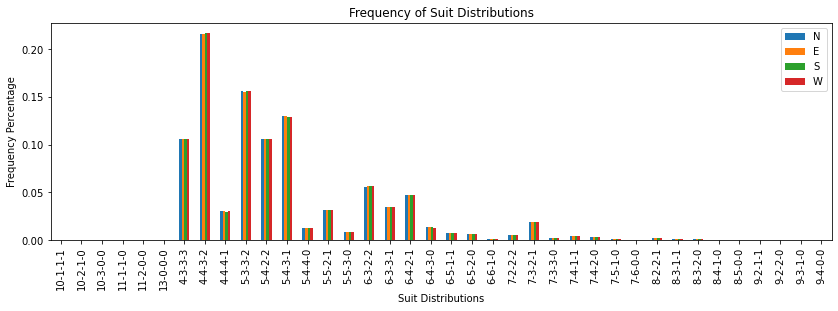

In [21]:
# plot frequency of max exp contracts
plotd = {}
for d in mlBridgeLib.NESW:
    plotd[d] = augmented_df[f'SL_{d}_ML_SJ'].value_counts(normalize=True).sort_index()
pd.DataFrame(plotd).plot(kind='bar',figsize=(14,4), xlabel='Suit Distributions', ylabel='Frequency Percentage', title='Frequency of Suit Distributions')

In [22]:
# takes 5s
dist_points = [3,2,1]+[0]*11 # using traditional distribution points metric
assert len(dist_points) == 14 # 14 possible suit lengths
for d in mlBridgeLib.NESW:
    augmented_df[f'DP_{d}'] = augmented_df[f'SL_{d}_{so}'].map(lambda l: sum([dist_points[v] for v in l])).astype('uint8')
augmented_df.filter(regex=f'^(DP_.|SL_._{so})$')

,SL_N_CDHS,SL_E_CDHS,SL_S_CDHS,SL_W_CDHS,DP_N,DP_E,DP_S,DP_W
0,"[2, 3, 2, 6]","[4, 1, 5, 3]","[2, 6, 2, 3]","[5, 3, 4, 1]",2,2,2,2
1,"[3, 2, 3, 5]","[4, 3, 3, 3]","[3, 4, 4, 2]","[3, 4, 3, 3]",1,0,1,0
2,"[1, 3, 4, 5]","[4, 1, 5, 3]","[3, 6, 2, 2]","[5, 3, 2, 3]",2,2,2,1
3,"[1, 6, 2, 4]","[3, 2, 3, 5]","[7, 4, 1, 1]","[2, 1, 7, 3]",3,1,4,3
4,"[1, 5, 2, 5]","[5, 3, 4, 1]","[3, 3, 4, 3]","[4, 2, 3, 4]",3,2,0,1
5,"[2, 5, 1, 5]","[4, 2, 5, 2]","[4, 3, 2, 4]","[3, 3, 5, 2]",3,2,1,1
6,"[3, 5, 4, 1]","[2, 3, 3, 5]","[4, 3, 2, 4]","[4, 2, 4, 3]",2,1,1,1
7,"[3, 5, 2, 3]","[3, 3, 4, 3]","[3, 2, 5, 3]","[4, 3, 2, 4]",1,0,1,1
8,"[2, 5, 2, 4]","[5, 2, 4, 2]","[4, 2, 5, 2]","[2, 4, 2, 5]",2,2,2,2
9,"[3, 3, 5, 2]","[2, 4, 5, 2]","[2, 3, 2, 6]","[6, 3, 1, 3]",1,2,2,2


<AxesSubplot:title={'center':'Frequency of Suit Distribution Points'}, xlabel='Suit Distribution Points', ylabel='Frequency Percentage'>

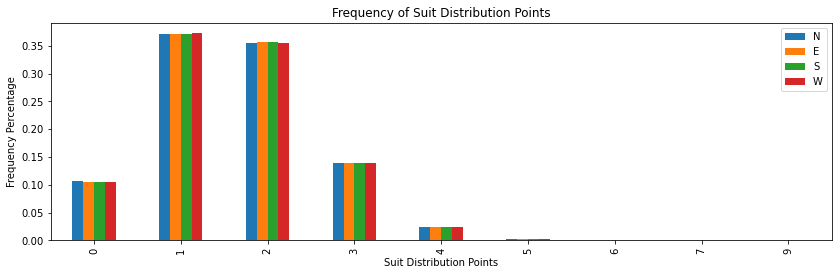

In [23]:
# plot frequency of max exp contracts
plotd = {}
for d in mlBridgeLib.NESW:
    plotd[d] = augmented_df[f'DP_{d}'].value_counts(normalize=True).sort_index()
pd.DataFrame(plotd).plot(kind='bar',figsize=(14,4), xlabel='Suit Distribution Points', ylabel='Frequency Percentage', title='Frequency of Suit Distribution Points')

In [24]:
# takes 8s
# Create columns for partnership (NS,EW). e.g. HCP_NS, HCP_EW, HCP_EW_C, ...
sum_ns_ew = [('HCP','int8'), ('QT','float32'), ('SL','int8')]
for c,t in sum_ns_ew:
    for d in mlBridgeLib.NS_EW:
        if '_'.join([c,d[0]]) in augmented_df.columns:
            augmented_df['_'.join([c,d])] = augmented_df[['_'.join([c,d[0]]),'_'.join([c,d[1]])]].sum(axis='columns').astype(t) # e.g. HCP_NS = HCP_N + HCP_S
        for s in mlBridgeLib.SHDC:
            augmented_df['_'.join([c,d,s])] = augmented_df[['_'.join([c,d[0],s]), '_'.join([c,d[1],s])]].sum(axis='columns').astype(t)
max_ns_ew = [('DD','int8')]
for c,t in max_ns_ew:
    for d in mlBridgeLib.NS_EW:
        for s in mlBridgeLib.CDHSN:
            augmented_df['_'.join([c,d,s])] = augmented_df[['_'.join([c,d[0],s]), '_'.join([c,d[1],s])]].max(axis='columns').astype(t)
augmented_df

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W,HCP,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C,QT,QT_N,...,SL_N_ML_S,SL_N_ML_SI,SL_N_ML_SJ,SL_E_CDHS,SL_E_CDHS_J,SL_E_ML_S,SL_E_ML_SI,SL_E_ML_SJ,SL_S_CDHS,SL_S_CDHS_J,SL_S_ML_S,SL_S_ML_SI,SL_S_ML_SJ,SL_W_CDHS,SL_W_CDHS_J,SL_W_ML_S,SL_W_ML_SI,SL_W_ML_SJ,DP_N,DP_E,DP_S,DP_W,HCP_NS,HCP_NS_S,HCP_NS_H,HCP_NS_D,HCP_NS_C,HCP_EW,HCP_EW_S,HCP_EW_H,HCP_EW_D,HCP_EW_C,QT_NS,QT_NS_S,QT_NS_H,QT_NS_D,QT_NS_C,QT_EW,QT_EW_S,QT_EW_H,QT_EW_D,QT_EW_C,SL_NS_S,SL_NS_H,SL_NS_D,SL_NS_C,SL_EW_S,SL_EW_H,SL_EW_D,SL_EW_C,DD_NS_C,DD_NS_D,DD_NS_H,DD_NS_S,DD_NS_N,DD_EW_C,DD_EW_D,DD_EW_H,DD_EW_S,DD_EW_N
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000,"((9, (0, 3, 1, 5)), (14, (4, 2, 5, 3)), (12, (3, 5, 4, 0)), (5, (3, 0, 0, 2)))",9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2,"(6.5, ((1.5, (0, 0.5, 0, 1)), (2.5, (1, 0, 1, 0.5)), (2.5, (0.5, 1, 1, 0)), (0, (0, 0, 0, 0))))",1.50,...,"[6, 3, 2, 2]","[3, 1, 0, 2]",6-3-2-2,"[4, 1, 5, 3]",4-1-5-3,"[5, 4, 3, 1]","[2, 0, 3, 1]",5-4-3-1,"[2, 6, 2, 3]",2-6-2-3,"[6, 3, 2, 2]","[1, 3, 0, 2]",6-3-2-2,"[5, 3, 4, 1]",5-3-4-1,"[5, 4, 3, 1]","[0, 2, 1, 3]",5-4-3-1,2,2,2,2,21,3,8,5,5,19,7,2,5,5,4.00,0.50,1.50,1.00,1.00,2.50,1.00,0.00,1.00,0.50,4,9,4,9,9,4,9,4,10,4,10,4,8,2,9,3,9,2
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100,"((9, (0, 4, 1, 4)), (9, (5, 0, 0, 4)), (13, (3, 2, 6, 2)), (9, (2, 4, 3, 0)))",9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0,"(6.5, ((1.0, (0, 0.5, 0, 0.5)), (2, (1, 0, 0, 1)), (2.0, (0.5, 0, 1.5, 0)), (1.5, (0, 1, 0.5, 0))))",1.00,...,"[5, 3, 3, 2]","[3, 0, 2, 1]",5-3-3-2,"[4, 3, 3, 3]",4-3-3-3,"[4, 3, 3, 3]","[0, 1, 2, 3]",4-3-3-3,"[3, 4, 4, 2]",3-4-4-2,"[4, 4, 3, 2]","[1, 2, 0, 3]",4-4-3-2,"[3, 4, 3, 3]",3-4-3-3,"[4, 3, 3, 3]","[1, 0, 2, 3]",4-3-3-3,1,0,1,0,22,3,6,7,6,18,7,4,3,4,3.00,0.50,0.50,1.50,0.50,3.50,1.00,1.00,0.50,1.00,6,6,7,7,7,7,6,6,8,8,7,7,7,4,5,6,6,6
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6,"((0b100000000000000011010010100100000010011000011010, (0b100000000, 0b110100, 0b1010010000001, 0...",0b1000000000000000110100101001000000100110

In [25]:
# takes 3s
# Create columns of longest suit.
sl_cols = [('_'.join(['SL_Max',d]),['_'.join(['SL',d,s]) for s in mlBridgeLib.SHDC]) for d in mlBridgeLib.NS_EW]
for d in sl_cols:
    augmented_df[d[0]] = augmented_df[d[1]].idxmax(axis=1).astype('category') # defaults to object so need string or category
augmented_df[[c[0] for c in sl_cols]]

,SL_Max_NS,SL_Max_EW
0,SL_NS_H,SL_EW_S
1,SL_NS_D,SL_EW_S
2,SL_NS_H,SL_EW_S
3,SL_NS_H,SL_EW_D
4,SL_NS_H,SL_EW_S
5,SL_NS_C,SL_EW_D
6,SL_NS_H,SL_EW_C
7,SL_NS_H,SL_EW_S
8,SL_NS_H,SL_EW_S
9,SL_NS_C,SL_EW_S


In [26]:
augmented_df.iloc[0][augmented_df.columns.str.startswith('QT')]

QT         (6.5, ((1.5, (0, 0.5, 0, 1)), (2.5, (1, 0, 1, 0.5)), (2.5, (0.5, 1, 1, 0)), (0, (0, 0, 0, 0))))
QT_N                                                                                                  1.50
QT_N_S                                                                                                0.00
QT_N_H                                                                                                0.50
QT_N_D                                                                                                0.00
QT_N_C                                                                                                1.00
QT_E                                                                                                  2.50
QT_E_S                                                                                                1.00
QT_E_H                                                                                                0.00
QT_E_D                               

In [27]:
augmented_df.dtypes

ref                      object
hand_record_id           object
event_id                  int64
Board                    string
EventBoard               string
Dealer                   object
Vul                      object
board_record_string      object
Hands                    object
Par                      object
DDmakes                  object
brs_dup                    bool
DD_N_C                     int8
DD_N_D                     int8
DD_N_H                     int8
DD_N_S                     int8
DD_N_N                     int8
DD_E_C                     int8
DD_E_D                     int8
DD_E_H                     int8
DD_E_S                     int8
DD_E_N                     int8
DD_S_C                     int8
DD_S_D                     int8
DD_S_H                     int8
                         ...   
QT_EW                   float32
QT_EW_S                 float32
QT_EW_H                 float32
QT_EW_D                 float32
QT_EW_C                 float32
SL_NS_S 

In [28]:
# takes 15s
# Create columns of Par_Score. Give it 'int16' dtype.
#augmented_df['Par_Score'] = [par[0] for par in augmented_df['Par']]
#augmented_df['Par_Score'] = augmented_df['Par_Score'].astype('int16') # note: using 'int16' for Par_Score
#augmented_df

In [29]:
# takes 8s
# Create columns of Par_Score. Give it 'category' dtype.
augmented_df['Par_Score'] = [par[0] for par in augmented_df['Par']]
augmented_df['Par_Score'] = augmented_df['Par_Score'].astype('category') # note: using 'category' for Par_Score
augmented_df

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W,HCP,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C,QT,QT_N,...,SL_E_CDHS,SL_E_CDHS_J,SL_E_ML_S,SL_E_ML_SI,SL_E_ML_SJ,SL_S_CDHS,SL_S_CDHS_J,SL_S_ML_S,SL_S_ML_SI,SL_S_ML_SJ,SL_W_CDHS,SL_W_CDHS_J,SL_W_ML_S,SL_W_ML_SI,SL_W_ML_SJ,DP_N,DP_E,DP_S,DP_W,HCP_NS,HCP_NS_S,HCP_NS_H,HCP_NS_D,HCP_NS_C,HCP_EW,HCP_EW_S,HCP_EW_H,HCP_EW_D,HCP_EW_C,QT_NS,QT_NS_S,QT_NS_H,QT_NS_D,QT_NS_C,QT_EW,QT_EW_S,QT_EW_H,QT_EW_D,QT_EW_C,SL_NS_S,SL_NS_H,SL_NS_D,SL_NS_C,SL_EW_S,SL_EW_H,SL_EW_D,SL_EW_C,DD_NS_C,DD_NS_D,DD_NS_H,DD_NS_S,DD_NS_N,DD_EW_C,DD_EW_D,DD_EW_H,DD_EW_S,DD_EW_N,SL_Max_NS,SL_Max_EW,Par_Score
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000,"((9, (0, 3, 1, 5)), (14, (4, 2, 5, 3)), (12, (3, 5, 4, 0)), (5, (3, 0, 0, 2)))",9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2,"(6.5, ((1.5, (0, 0.5, 0, 1)), (2.5, (1, 0, 1, 0.5)), (2.5, (0.5, 1, 1, 0)), (0, (0, 0, 0, 0))))",1.50,...,"[4, 1, 5, 3]",4-1-5-3,"[5, 4, 3, 1]","[2, 0, 3, 1]",5-4-3-1,"[2, 6, 2, 3]",2-6-2-3,"[6, 3, 2, 2]","[1, 3, 0, 2]",6-3-2-2,"[5, 3, 4, 1]",5-3-4-1,"[5, 4, 3, 1]","[0, 2, 1, 3]",5-4-3-1,2,2,2,2,21,3,8,5,5,19,7,2,5,5,4.00,0.50,1.50,1.00,1.00,2.50,1.00,0.00,1.00,0.50,4,9,4,9,9,4,9,4,10,4,10,4,8,2,9,3,9,2,SL_NS_H,SL_EW_S,200
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100,"((9, (0, 4, 1, 4)), (9, (5, 0, 0, 4)), (13, (3, 2, 6, 2)), (9, (2, 4, 3, 0)))",9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0,"(6.5, ((1.0, (0, 0.5, 0, 0.5)), (2, (1, 0, 0, 1)), (2.0, (0.5, 0, 1.5, 0)), (1.5, (0, 1, 0.5, 0))))",1.00,...,"[4, 3, 3, 3]",4-3-3-3,"[4, 3, 3, 3]","[0, 1, 2, 3]",4-3-3-3,"[3, 4, 4, 2]",3-4-4-2,"[4, 4, 3, 2]","[1, 2, 0, 3]",4-4-3-2,"[3, 4, 3, 3]",3-4-3-3,"[4, 3, 3, 3]","[1, 0, 2, 3]",4-3-3-3,1,0,1,0,22,3,6,7,6,18,7,4,3,4,3.00,0.50,0.50,1.50,0.50,3.50,1.00,1.00,0.50,1.00,6,6,7,7,7,7,6,6,8,8,7,7,7,4,5,6,6,6,SL_NS_D,SL_EW_S,90
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6,"((0b100000000000000011010010100100000010011000011010, (0b100000000, 0b110100, 0b1010010000001, 0...",0b100000000000000011010010100100000010011000011010,0b1000110001000000000001000000

In [30]:
# takes 20s
# Create column of contract types by partnership by suit. e.g. CT_NS_C.
contract_types_d = mlBridgeLib.CategorifyContractType(augmented_df['DDmakes'])
contract_types_df = pd.DataFrame(contract_types_d,dtype='category')
display(contract_types_df.dtypes,contract_types_df.head())
assert len(augmented_df) == len(contract_types_df)
augmented_df = pd.concat([augmented_df,contract_types_df],axis='columns',join='inner')
del contract_types_df,contract_types_d
display(augmented_df.dtypes,augmented_df)

CT_NS_C    category
CT_NS_D    category
CT_NS_H    category
CT_NS_S    category
CT_NS_N    category
CT_EW_C    category
CT_EW_D    category
CT_EW_H    category
CT_EW_S    category
CT_EW_N    category
dtype: object

,CT_NS_C,CT_NS_D,CT_NS_H,CT_NS_S,CT_NS_N,CT_EW_C,CT_EW_D,CT_EW_H,CT_EW_S,CT_EW_N
0,Partial,Pass,Game,Pass,Partial,Pass,Partial,Pass,Partial,Pass
1,Partial,Partial,Partial,Partial,Partial,Pass,Pass,Pass,Pass,Pass
2,Partial,Partial,Partial,Pass,Pass,Pass,Pass,Pass,Partial,Pass
3,Pass,Pass,Game,Partial,Pass,Game,Game,Pass,Pass,Game
4,Pass,Pass,Pass,Pass,Pass,Partial,Game,Pass,SSlam,Partial


ref                      object
hand_record_id           object
event_id                  int64
Board                    string
EventBoard               string
Dealer                   object
Vul                      object
board_record_string      object
Hands                    object
Par                      object
DDmakes                  object
brs_dup                    bool
DD_N_C                     int8
DD_N_D                     int8
DD_N_H                     int8
DD_N_S                     int8
DD_N_N                     int8
DD_E_C                     int8
DD_E_D                     int8
DD_E_H                     int8
DD_E_S                     int8
DD_E_N                     int8
DD_S_C                     int8
DD_S_D                     int8
DD_S_H                     int8
                         ...   
SL_EW_D                    int8
SL_EW_C                    int8
DD_NS_C                    int8
DD_NS_D                    int8
DD_NS_H                    int8
DD_NS_S 

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W,HCP,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C,QT,QT_N,...,SL_W_CDHS,SL_W_CDHS_J,SL_W_ML_S,SL_W_ML_SI,SL_W_ML_SJ,DP_N,DP_E,DP_S,DP_W,HCP_NS,HCP_NS_S,HCP_NS_H,HCP_NS_D,HCP_NS_C,HCP_EW,HCP_EW_S,HCP_EW_H,HCP_EW_D,HCP_EW_C,QT_NS,QT_NS_S,QT_NS_H,QT_NS_D,QT_NS_C,QT_EW,QT_EW_S,QT_EW_H,QT_EW_D,QT_EW_C,SL_NS_S,SL_NS_H,SL_NS_D,SL_NS_C,SL_EW_S,SL_EW_H,SL_EW_D,SL_EW_C,DD_NS_C,DD_NS_D,DD_NS_H,DD_NS_S,DD_NS_N,DD_EW_C,DD_EW_D,DD_EW_H,DD_EW_S,DD_EW_N,SL_Max_NS,SL_Max_EW,Par_Score,CT_NS_C,CT_NS_D,CT_NS_H,CT_NS_S,CT_NS_N,CT_EW_C,CT_EW_D,CT_EW_H,CT_EW_S,CT_EW_N
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000,"((9, (0, 3, 1, 5)), (14, (4, 2, 5, 3)), (12, (3, 5, 4, 0)), (5, (3, 0, 0, 2)))",9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2,"(6.5, ((1.5, (0, 0.5, 0, 1)), (2.5, (1, 0, 1, 0.5)), (2.5, (0.5, 1, 1, 0)), (0, (0, 0, 0, 0))))",1.50,...,"[5, 3, 4, 1]",5-3-4-1,"[5, 4, 3, 1]","[0, 2, 1, 3]",5-4-3-1,2,2,2,2,21,3,8,5,5,19,7,2,5,5,4.00,0.50,1.50,1.00,1.00,2.50,1.00,0.00,1.00,0.50,4,9,4,9,9,4,9,4,10,4,10,4,8,2,9,3,9,2,SL_NS_H,SL_EW_S,200,Partial,Pass,Game,Pass,Partial,Pass,Partial,Pass,Partial,Pass
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100,"((9, (0, 4, 1, 4)), (9, (5, 0, 0, 4)), (13, (3, 2, 6, 2)), (9, (2, 4, 3, 0)))",9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0,"(6.5, ((1.0, (0, 0.5, 0, 0.5)), (2, (1, 0, 0, 1)), (2.0, (0.5, 0, 1.5, 0)), (1.5, (0, 1, 0.5, 0))))",1.00,...,"[3, 4, 3, 3]",3-4-3-3,"[4, 3, 3, 3]","[1, 0, 2, 3]",4-3-3-3,1,0,1,0,22,3,6,7,6,18,7,4,3,4,3.00,0.50,0.50,1.50,0.50,3.50,1.00,1.00,0.50,1.00,6,6,7,7,7,7,6,6,8,8,7,7,7,4,5,6,6,6,SL_NS_D,SL_EW_S,90,Partial,Partial,Partial,Partial,Partial,Pass,Pass,Pass,Pass,Pass
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3, H, , NS, 0)])","((9, 7, 9, 4, 6), (4, 6, 3, 8, 6), (9, 7, 9, 5, 6), (4, 6, 3, 8, 6))",False,9,7,9,4,6,4,6,3,8,6,9,7,9,5,6,4,6,3,8,6,"((0b100000000000000011010010100100000010011000011010, (0b100000000, 0b110100, 0b1010010000001, 0...",0b100000000000000011010010100100000010011000011010,0b100011000100000000000100000001011001100000011100000,0b1000000001001101001100001101010000000000000000000101,0b11000110010010110000000000000000110001100100000000,"((9, (0, 0, 

In [31]:
# takes 8s
# Create columns of contract types by partnership by suit by contract. e.g. CT_NS_C_Game
contract_types_d = {}
cols = augmented_df.filter(regex=r'CT_(NS|EW)_[CDHSN]').columns
for c in cols:
    for t in mlBridgeLib.contract_types:
        print(c,t,len((t == augmented_df[c]).values))
        new_c = c+'_'+t
        contract_types_d[new_c] = (t == augmented_df[c]).values
#contract_types_d = CategorifyContractType(augmented_df['DDmakes'])
contract_types_df = pd.DataFrame(contract_types_d)
display(contract_types_df.dtypes,contract_types_df.head())
assert len(augmented_df) == len(contract_types_df)
augmented_df = pd.concat([augmented_df,contract_types_df],axis='columns',join='inner')
del contract_types_df,contract_types_d
display(augmented_df.dtypes,augmented_df)

CT_NS_C Pass 1741626
CT_NS_C Partial 1741626
CT_NS_C Game 1741626
CT_NS_C SSlam 1741626
CT_NS_C GSlam 1741626
CT_NS_D Pass 1741626
CT_NS_D Partial 1741626
CT_NS_D Game 1741626
CT_NS_D SSlam 1741626
CT_NS_D GSlam 1741626
CT_NS_H Pass 1741626
CT_NS_H Partial 1741626
CT_NS_H Game 1741626
CT_NS_H SSlam 1741626
CT_NS_H GSlam 1741626
CT_NS_S Pass 1741626
CT_NS_S Partial 1741626
CT_NS_S Game 1741626
CT_NS_S SSlam 1741626
CT_NS_S GSlam 1741626
CT_NS_N Pass 1741626
CT_NS_N Partial 1741626
CT_NS_N Game 1741626
CT_NS_N SSlam 1741626
CT_NS_N GSlam 1741626
CT_EW_C Pass 1741626
CT_EW_C Partial 1741626
CT_EW_C Game 1741626
CT_EW_C SSlam 1741626
CT_EW_C GSlam 1741626
CT_EW_D Pass 1741626
CT_EW_D Partial 1741626
CT_EW_D Game 1741626
CT_EW_D SSlam 1741626
CT_EW_D GSlam 1741626
CT_EW_H Pass 1741626
CT_EW_H Partial 1741626
CT_EW_H Game 1741626
CT_EW_H SSlam 1741626
CT_EW_H GSlam 1741626
CT_EW_S Pass 1741626
CT_EW_S Partial 1741626
CT_EW_S Game 1741626
CT_EW_S SSlam 1741626
CT_EW_S GSlam 1741626
CT_EW_N Pa

CT_NS_C_Pass       bool
CT_NS_C_Partial    bool
CT_NS_C_Game       bool
CT_NS_C_SSlam      bool
CT_NS_C_GSlam      bool
CT_NS_D_Pass       bool
CT_NS_D_Partial    bool
CT_NS_D_Game       bool
CT_NS_D_SSlam      bool
CT_NS_D_GSlam      bool
CT_NS_H_Pass       bool
CT_NS_H_Partial    bool
CT_NS_H_Game       bool
CT_NS_H_SSlam      bool
CT_NS_H_GSlam      bool
CT_NS_S_Pass       bool
CT_NS_S_Partial    bool
CT_NS_S_Game       bool
CT_NS_S_SSlam      bool
CT_NS_S_GSlam      bool
CT_NS_N_Pass       bool
CT_NS_N_Partial    bool
CT_NS_N_Game       bool
CT_NS_N_SSlam      bool
CT_NS_N_GSlam      bool
CT_EW_C_Pass       bool
CT_EW_C_Partial    bool
CT_EW_C_Game       bool
CT_EW_C_SSlam      bool
CT_EW_C_GSlam      bool
CT_EW_D_Pass       bool
CT_EW_D_Partial    bool
CT_EW_D_Game       bool
CT_EW_D_SSlam      bool
CT_EW_D_GSlam      bool
CT_EW_H_Pass       bool
CT_EW_H_Partial    bool
CT_EW_H_Game       bool
CT_EW_H_SSlam      bool
CT_EW_H_GSlam      bool
CT_EW_S_Pass       bool
CT_EW_S_Partial 

,CT_NS_C_Pass,CT_NS_C_Partial,CT_NS_C_Game,CT_NS_C_SSlam,CT_NS_C_GSlam,CT_NS_D_Pass,CT_NS_D_Partial,CT_NS_D_Game,CT_NS_D_SSlam,CT_NS_D_GSlam,CT_NS_H_Pass,CT_NS_H_Partial,CT_NS_H_Game,CT_NS_H_SSlam,CT_NS_H_GSlam,CT_NS_S_Pass,CT_NS_S_Partial,CT_NS_S_Game,CT_NS_S_SSlam,CT_NS_S_GSlam,CT_NS_N_Pass,CT_NS_N_Partial,CT_NS_N_Game,CT_NS_N_SSlam,CT_NS_N_GSlam,CT_EW_C_Pass,CT_EW_C_Partial,CT_EW_C_Game,CT_EW_C_SSlam,CT_EW_C_GSlam,CT_EW_D_Pass,CT_EW_D_Partial,CT_EW_D_Game,CT_EW_D_SSlam,CT_EW_D_GSlam,CT_EW_H_Pass,CT_EW_H_Partial,CT_EW_H_Game,CT_EW_H_SSlam,CT_EW_H_GSlam,CT_EW_S_Pass,CT_EW_S_Partial,CT_EW_S_Game,CT_EW_S_SSlam,CT_EW_S_GSlam,CT_EW_N_Pass,CT_EW_N_Partial,CT_EW_N_Game,CT_EW_N_SSlam,CT_EW_N_GSlam
0,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False
1,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False
2,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False
3,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False
4,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False


ref                    object
hand_record_id         object
event_id                int64
Board                  string
EventBoard             string
Dealer                 object
Vul                    object
board_record_string    object
Hands                  object
Par                    object
DDmakes                object
brs_dup                  bool
DD_N_C                   int8
DD_N_D                   int8
DD_N_H                   int8
DD_N_S                   int8
DD_N_N                   int8
DD_E_C                   int8
DD_E_D                   int8
DD_E_H                   int8
DD_E_S                   int8
DD_E_N                   int8
DD_S_C                   int8
DD_S_D                   int8
DD_S_H                   int8
                        ...  
CT_EW_C_Pass             bool
CT_EW_C_Partial          bool
CT_EW_C_Game             bool
CT_EW_C_SSlam            bool
CT_EW_C_GSlam            bool
CT_EW_D_Pass             bool
CT_EW_D_Partial          bool
CT_EW_D_Ga

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W,HCP,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C,QT,QT_N,...,CT_NS_C,CT_NS_D,CT_NS_H,CT_NS_S,CT_NS_N,CT_EW_C,CT_EW_D,CT_EW_H,CT_EW_S,CT_EW_N,CT_NS_C_Pass,CT_NS_C_Partial,CT_NS_C_Game,CT_NS_C_SSlam,CT_NS_C_GSlam,CT_NS_D_Pass,CT_NS_D_Partial,CT_NS_D_Game,CT_NS_D_SSlam,CT_NS_D_GSlam,CT_NS_H_Pass,CT_NS_H_Partial,CT_NS_H_Game,CT_NS_H_SSlam,CT_NS_H_GSlam,CT_NS_S_Pass,CT_NS_S_Partial,CT_NS_S_Game,CT_NS_S_SSlam,CT_NS_S_GSlam,CT_NS_N_Pass,CT_NS_N_Partial,CT_NS_N_Game,CT_NS_N_SSlam,CT_NS_N_GSlam,CT_EW_C_Pass,CT_EW_C_Partial,CT_EW_C_Game,CT_EW_C_SSlam,CT_EW_C_GSlam,CT_EW_D_Pass,CT_EW_D_Partial,CT_EW_D_Game,CT_EW_D_SSlam,CT_EW_D_GSlam,CT_EW_H_Pass,CT_EW_H_Partial,CT_EW_H_Game,CT_EW_H_SSlam,CT_EW_H_GSlam,CT_EW_S_Pass,CT_EW_S_Partial,CT_EW_S_Game,CT_EW_S_SSlam,CT_EW_S_GSlam,CT_EW_N_Pass,CT_EW_N_Partial,CT_EW_N_Game,CT_EW_N_SSlam,CT_EW_N_GSlam
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000,"((9, (0, 3, 1, 5)), (14, (4, 2, 5, 3)), (12, (3, 5, 4, 0)), (5, (3, 0, 0, 2)))",9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2,"(6.5, ((1.5, (0, 0.5, 0, 1)), (2.5, (1, 0, 1, 0.5)), (2.5, (0.5, 1, 1, 0)), (0, (0, 0, 0, 0))))",1.50,...,Partial,Pass,Game,Pass,Partial,Pass,Partial,Pass,Partial,Pass,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100,"((9, (0, 4, 1, 4)), (9, (5, 0, 0, 4)), (13, (3, 2, 6, 2)), (9, (2, 4, 3, 0)))",9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0,"(6.5, ((1.0, (0, 0.5, 0, 0.5)), (2, (1, 0, 0, 1)), (2.0, (0.5, 0, 1.5, 0)), (1.5, (0, 1, 0.5, 0))))",1.00,...,Partial,Partial,Partial,Partial,Partial,Pass,Pass,Pass,Pass,Pass,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT)

In [32]:
# todo: problem is there can be multiple par contracts, multiple directions, multiple results (down 1, make 400, etc.)
#augmented_df['Par_Level'] = [par[0] for par in augmented_df['Par']]
#augmented_df
#augmented_df['Par_Suit'] = [par[0] for par in augmented_df['Par']]
#augmented_df
#augmented_df['Par_Dir'] = [par[0] for par in augmented_df['Par']]
#augmented_df
#augmented_df['Par_Result'] = [par[0] for par in augmented_df['Par']]
#augmented_df

In [33]:
# takes 5s
# Create columns of vulnerability by partnership.
augmented_df['Vul_NS'] = augmented_df['Vul'].isin(['N_S','Both'])
augmented_df['Vul_EW'] = augmented_df['Vul'].isin(['E_W','Both'])
augmented_df

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,brs_dup,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W,HCP,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C,QT,QT_N,...,CT_NS_H,CT_NS_S,CT_NS_N,CT_EW_C,CT_EW_D,CT_EW_H,CT_EW_S,CT_EW_N,CT_NS_C_Pass,CT_NS_C_Partial,CT_NS_C_Game,CT_NS_C_SSlam,CT_NS_C_GSlam,CT_NS_D_Pass,CT_NS_D_Partial,CT_NS_D_Game,CT_NS_D_SSlam,CT_NS_D_GSlam,CT_NS_H_Pass,CT_NS_H_Partial,CT_NS_H_Game,CT_NS_H_SSlam,CT_NS_H_GSlam,CT_NS_S_Pass,CT_NS_S_Partial,CT_NS_S_Game,CT_NS_S_SSlam,CT_NS_S_GSlam,CT_NS_N_Pass,CT_NS_N_Partial,CT_NS_N_Game,CT_NS_N_SSlam,CT_NS_N_GSlam,CT_EW_C_Pass,CT_EW_C_Partial,CT_EW_C_Game,CT_EW_C_SSlam,CT_EW_C_GSlam,CT_EW_D_Pass,CT_EW_D_Partial,CT_EW_D_Game,CT_EW_D_SSlam,CT_EW_D_GSlam,CT_EW_H_Pass,CT_EW_H_Partial,CT_EW_H_Game,CT_EW_H_SSlam,CT_EW_H_GSlam,CT_EW_S_Pass,CT_EW_S_Partial,CT_EW_S_Game,CT_EW_S_SSlam,CT_EW_S_GSlam,CT_EW_N_Pass,CT_EW_N_Partial,CT_EW_N_Game,CT_EW_N_SSlam,CT_EW_N_GSlam,Vul_NS,Vul_EW
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",False,10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000,"((9, (0, 3, 1, 5)), (14, (4, 2, 5, 3)), (12, (3, 5, 4, 0)), (5, (3, 0, 0, 2)))",9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2,"(6.5, ((1.5, (0, 0.5, 0, 1)), (2.5, (1, 0, 1, 0.5)), (2.5, (0.5, 1, 1, 0)), (0, (0, 0, 0, 0))))",1.50,...,Game,Pass,Partial,Pass,Partial,Pass,Partial,Pass,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",False,8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100,"((9, (0, 4, 1, 4)), (9, (5, 0, 0, 4)), (13, (3, 2, 6, 2)), (9, (2, 4, 3, 0)))",9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0,"(6.5, ((1.0, (0, 0.5, 0, 0.5)), (2, (1, 0, 0, 1)), (2.0, (0.5, 0, 1.5, 0)), (1.5, (0, 1, 0.5, 0))))",1.00,...,Partial,Partial,Partial,Pass,Pass,Pass,Pass,Pass,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,True
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, 

In [34]:
# takes 50s
# save augmented_df
acbl_hand_records_augmented_filename = 'acbl_hand_records_augmented.pkl'
acbl_hand_records_augmented_file = acblPath.joinpath(acbl_hand_records_augmented_filename)
with open(acbl_hand_records_augmented_file, 'wb') as f:
    pickle.dump(augmented_df, f)
print(f"Saved {acbl_hand_records_augmented_filename}: size:{acbl_hand_records_augmented_file.stat().st_size}")

Saved acbl_hand_records_augmented.pkl: size:2705936159
